In [3]:
#correlation matrix
library(FactoMineR)
library(RSQLite)
drv = SQLite()
conn = dbConnect(drv, dbname = './database')
# #getting max exp for genes where dev expression is highest, then bind to results for not dev expression
result <- dbGetQuery(conn, 'SELECT 
                              gene_features.id, 
                              gene_features.gLength,
                              gene_features.cds_len,  
                              gene_features.unique_domains, 
                              gene_features.domains, 
                              gene_features.motif_number, 
                              gene_features.gc3, 
                              gene_features.max_exp, 
                              gene_features.specificity,
                              gene_features.trans_count,
                              gene_features.intron_count,
                              gene_features.intron_length,
                              gene_features.avg_intron,
                              dn_ds,
                              dup_type
                            FROM 
                              gene_features
                            INNER JOIN 
                              macaque_paralogs 
                            ON 
                              gene_features.id == macaque_paralogs.id
                            WHERE 
                              macaque_paralogs.dn_ds 
                              AND macaque_paralogs.dn_ds < 10
                              AND (dup_type == "WGD" OR dup_type == "SSD")')[,-1]

result <- na.omit(result)
result$gLength <- log10(result$gLength)
result$max_exp <- log10(result$max_exp)
library("Hmisc")
res2 <- rcorr(as.matrix(result[,-14]), type = 'pearson')
corr <- res2$r
pval <- res2$P

write.csv(corr, file= 'corr.csv')
write.csv(pval, file= 'corr_pval.csv')

res3 <- rcorr(as.matrix(result[,-14]), type = 'spearman')
corr2 <- res3$r
pval2 <- res3$P

write.csv(corr2, file= 'corr_spearman.csv')
write.csv(pval2, file= 'corr_pval_spearman.csv')

# for (i in 1:length(names(result)))
# {
#     for (j in 1:length(names(result)))
#     {
#         cor = cor.test(result[,i], result[,j], method = 'pearson')
#         print(names(result[i]))
#         print(names(result[j]))
#         print(cor$p.value)
#         print(cor$estimate['cor'])
#     }
# }

Warning message:
“package ‘FactoMineR’ was built under R version 3.3.2”Warning message:
“package ‘RSQLite’ was built under R version 3.3.2”Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [4]:
corr_results <- result[,c(1:4,9:12)]
#PCA
png('tester.png', width = 1000, height = 500)
pca_res <- PCA(corr_results, graph = F)
plot(pca_res)
# pca_res$eig
# pca_res$var$cor
dev.off()

pdf 
  2

In [5]:
PCA1 <- pca_res$ind$coord[,1]

PCA2 <- pca_res$ind$coord[,2]

PCA3 <- pca_res$ind$coord[,3]

In [6]:
pca_res$eig
pca_res$var$cor
pca_res$var$contrib

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,3.4526980,43.158725,43.15873
comp 2,1.6731249,20.914062,64.07279
comp 3,1.0599604,13.249505,77.32229
comp 4,0.6674673,8.343341,85.66563
comp 5,0.4107315,5.134143,90.79978
comp 6,0.3106634,3.883292,94.68307
comp 7,0.2647610,3.309513,97.99258
comp 8,0.1605935,2.007418,100.00000


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
gLength,0.7785648,0.39550182,0.08014185,-0.10430750,-0.25040729
cds_len,0.7725972,-0.32154113,-0.05069059,-0.42013715,0.11081587
unique_domains,0.6200993,-0.42933835,-0.27645298,0.44251711,-0.36818491
domains,0.6239594,-0.49854650,-0.32407176,0.22689710,0.38730524
trans_count,0.3773750,0.04226238,0.82734060,0.36956357,0.14480837
intron_count,0.8272031,-0.24829023,0.27372555,-0.27497316,-0.07502992
intron_length,0.6957129,0.56505531,-0.08293758,0.02991892,0.06831313
avg_intron,0.4063083,0.77311893,-0.32128272,0.14030586,0.13753684


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
gLength,17.556219,9.3490740,0.6059393,1.6300505,15.266377
cds_len,17.288118,6.1793771,0.2424181,26.4455238,2.989826
unique_domains,11.136890,11.0171937,7.2102929,29.3379752,33.004564
domains,11.275975,14.8553526,9.9081537,7.7130811,36.521514
trans_count,4.124655,0.1067529,64.5771751,20.4620101,5.105395
intron_count,19.818270,3.6846047,7.0687244,11.3279310,1.370601
intron_length,14.018499,19.0833031,0.6489527,0.1341102,1.136188
avg_intron,4.781374,35.7243419,9.7383436,2.9493182,4.605535


In [7]:
non_corr <- result[,c(5:8,13,14)]

In [8]:
final_df <- cbind(non_corr, PCA1, PCA2, PCA3)
# glm

In [9]:
for(i in 1:nrow(final_df)) #makes 1 and 0 strings for some stupid reason
{
    if(final_df[i,]['dup_type'] == 'WGD')
    {
        final_df[i,]['dup_type'] <- 1
    }
    if(final_df[i,]['dup_type'] == 'SSD')
    {
        final_df[i,]['dup_type'] <- 0
    }
}

In [10]:
final_df$dup_type <- as.numeric(final_df$dup_type)
model <- glm(dup_type ~ . - specificity, data = final_df, family = binomial)

In [11]:
summary(model)


Call:
glm(formula = dup_type ~ . - specificity, family = binomial, 
    data = final_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5897  -1.0623   0.5797   1.0104   2.7909  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.888241   0.137797  -6.446 1.15e-10 ***
motif_number  0.006800   0.001073   6.339 2.31e-10 ***
gc3           1.959034   0.168076  11.656  < 2e-16 ***
max_exp       0.094844   0.043313   2.190 0.028543 *  
dn_ds        -1.836633   0.122292 -15.018  < 2e-16 ***
PCA1          0.251960   0.017652  14.274  < 2e-16 ***
PCA2          0.300711   0.025537  11.775  < 2e-16 ***
PCA3          0.105413   0.028482   3.701 0.000215 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 10830.2  on 7848  degrees of freedom
Residual deviance:  9582.5  on 7841  degrees of freedom
AIC: 9598.5

Number of Fisher Scoring iterations

In [194]:
for(i in 1:length(s$coefficients[,'Pr(>|t|)']))
{
    if(s$coefficients[,'Pr(>|t|)'][i] < 0.05)
    {
        print(row.names(s$coefficients)[i])
    }
}


[1] "(Intercept)"
[1] "exp"


In [19]:
pred <- predict(model, test, type='response')
actual <- test$dup_type
cbind(pred,actual)

,pred,actual
7477,0.7167871,1
7478,0.4271471,1
7479,0.2854026,1
7481,0.4914044,1
7482,0.3393714,0
7483,0.2933255,0
7484,0.4998211,1
7485,0.5814730,0
7486,0.9921102,1
7487,0.7306565,0


In [11]:
predict(model, test, type = 'response')

6245         6246         6247         6248         6249         6250 
4.525942e-01 4.220179e-01 4.201265e-01 3.994958e-01 3.665510e-01 3.796611e-01 
        6251         6252         6253         6255         6256         6258 
2.880822e-01 8.093412e-01 5.011375e-01 3.633531e-01 7.609666e-01 5.294951e-01 
        6259         6260         6261         6262         6263         6264 
4.596378e-01 1.677156e-01 3.234146e-01 3.800390e-01 4.137460e-01 3.729351e-01 
        6266         6267         6268         6270         6271         6272 
2.189911e-01 2.977774e-01 3.329623e-01 2.986274e-01 5.388904e-01 6.890666e-01 
        6273         6274         6275         6276         6277         6278 
3.451574e-01 3.225693e-01 3.716462e-01 4.379089e-01 6.338701e-01 3.734892e-01 
        6280         6281         6284         6285         6286         6287 
1.776769e-01 4.934743e-01 3.997233e-01 4.579554e-01 2.019669e-01 3.451805e-01 
        6288         6289         6294         6295         6296         6298 
7.776942e-01 5.545081e-01 6.416228e-01 6.966588e-01 2.344642e-01 3.892685e-01 
        6300         6302         6303         6304         6305         6306 
3.883804e-01 2.306106e-01 3.498071e-01 8.107569e-01 2.040654e-01 6.520529e-01 
        6307         6308         6309         6312         6313         6314 
2.172485e-01 4.742488e-01 3.929863e-01 5.437643e-01 7.335906e-01 2.237923e-01 
        6315         6317         6318         6320         6321         6322 
3.820251e-01 4.293874e-01 3.859079e-01 4.496397e-01 5.275901e-01 6.664169e-01 
        6323         6324         6326         6327         6328         6329 
5.655776e-01 7.820100e-01 7.848416e-01 6.544451e-01 6.304566e-01 3.368282e-01 
        6330         6331         6332         6333         6335         6336 
7.990240e-01 3.114276e-01 3.045684e-01 4.038466e-01 4.954680e-01 4.103471e-01 
        6337         6338         6339         6340         6341         6342 
5.126437e-01 4.404150e-01 5.135354e-01 2.155616e-01 4.010429e-01 3.874403e-01 
        6344         6345         6346         6348         6350         6352 
5.724712e-01 2.272282e-01 5.786776e-01 3.785131e-01 6.142799e-01 6.693616e-01 
        6353         6354         6355         6356         6358         6359 
7.519888e-01 9.030503e-01 3.985208e-01 4.601775e-01 5.195354e-01 7.078047e-01 
        6360         6361         6362         6363         6364         6367 
3.467470e-01 7.650562e-01 4.662065e-01 6.106398e-01 5.860832e-01 4.339966e-01 
        6369         6370         6371         6372         6373         6374 
3.751337e-01 6.818806e-01 4.488148e-01 4.372537e-01 3.728943e-01 3.591732e-01 
        6375         6376         6378         6379         6380         6382 
4.998589e-01 4.588573e-01 4.547599e-01 4.454564e-01 3.770247e-01 5.291592e-01 
        6383         6384         6386         6387         6388         6389 
3.222574e-01 3.107771e-01 6.658878e-01 3.506922e-01 3.553406e-01 5.943088e-01 
        6390         6391         6392         6393         6394         6397 
6.151705e-01 3.376034e-01 2.209149e-01 3.409488e-01 3.886901e-01 8.683681e-01 
        6399         6400         6401         6402         6403         6404 
5.170852e-01 6.853958e-01 3.477337e-01 3.275600e-01 4.214475e-01 8.719038e-01 
        6405         6406         6408         6409         6410         6412 
5.310718e-01 2.858639e-01 5.077096e-01 4.129875e-01 4.527953e-01 4.836123e-01 
        6413         6415         6417         6418         6419         6420 
3.267386e-01 1.686659e-01 4.607155e-01 5.011538e-01 8.964249e-01 4.871173e-01 
        6421         6422         6423         6425         6427         6428 
5.614890e-01 3.790859e-01 3.906036e-01 6.280635e-01 4.287279e-01 3.919470e-01 
        6429         6431         6432         6434         6436         6437 
4.611868e-01 8.580766e-01 5.296914e-01 3.113537e-01 6.212267e-01 6.162323e-01 
        6438         6439         6443         6444       

In [197]:
model_p

value 
    0

In [198]:
t_value

dn_ds 
-0.894679

In [199]:
std.error

dn_ds 
0.0790764

In [16]:
train <- final_df[1:6000,]
test <- final_df[6001:nrow(final_df),]


In [201]:
testing <- predict(model, test)

In [63]:
final_df$exp <- log10(final_df$exp)

In [21]:
print(RMSE)

[1] 6.704804


In [13]:
model <- glm(dup_type ~ (dn_ds + gc3 + PCA1 + PCA2)^2 - gc3*PCA1 - dn_ds*gc3, data = final_df, family = binomial)

summary(model)


Call:
glm(formula = dup_type ~ (dn_ds + gc3 + PCA1 + PCA2)^2 - gc3 * 
    PCA1 - dn_ds * gc3, family = binomial, data = final_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5192  -1.1649   0.7174   1.0860   2.8459  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.238224   0.024131   9.872  < 2e-16 ***
PCA2         1.155945   0.121906   9.482  < 2e-16 ***
dn_ds:PCA1   0.919610   0.053685  17.130  < 2e-16 ***
dn_ds:PCA2   0.410883   0.142396   2.885  0.00391 ** 
gc3:PCA2    -1.381027   0.165861  -8.326  < 2e-16 ***
PCA1:PCA2   -0.047058   0.008509  -5.531 3.19e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 10830  on 7848  degrees of freedom
Residual deviance: 10150  on 7843  degrees of freedom
AIC: 10162

Number of Fisher Scoring iterations: 4


In [61]:
range(final_df$PCA2)

[1] -18.08609  16.67879

In [14]:
d <- seq(6, 0, -0.01)
g <- seq(0.2, 1, length.out = length(d))
p1 <- seq(-4, 25, length.out = length(d))
p2 <- seq(-18, 17, length.out = length(d))

test_df <- data.frame(d,g,p1,p2)
names(test_df) <- c('dn_ds', 'gc3', 'PCA1', 'PCA2')
test_df[1:200,]

dn_ds,gc3,PCA1,PCA2
6.00,0.2000000,-4.000000,-18.00000
5.99,0.2013333,-3.951667,-17.94167
5.98,0.2026667,-3.903333,-17.88333
5.97,0.2040000,-3.855000,-17.82500
5.96,0.2053333,-3.806667,-17.76667
5.95,0.2066667,-3.758333,-17.70833
5.94,0.2080000,-3.710000,-17.65000
5.93,0.2093333,-3.661667,-17.59167
5.92,0.2106667,-3.613333,-17.53333
5.91,0.2120000,-3.565000,-17.47500


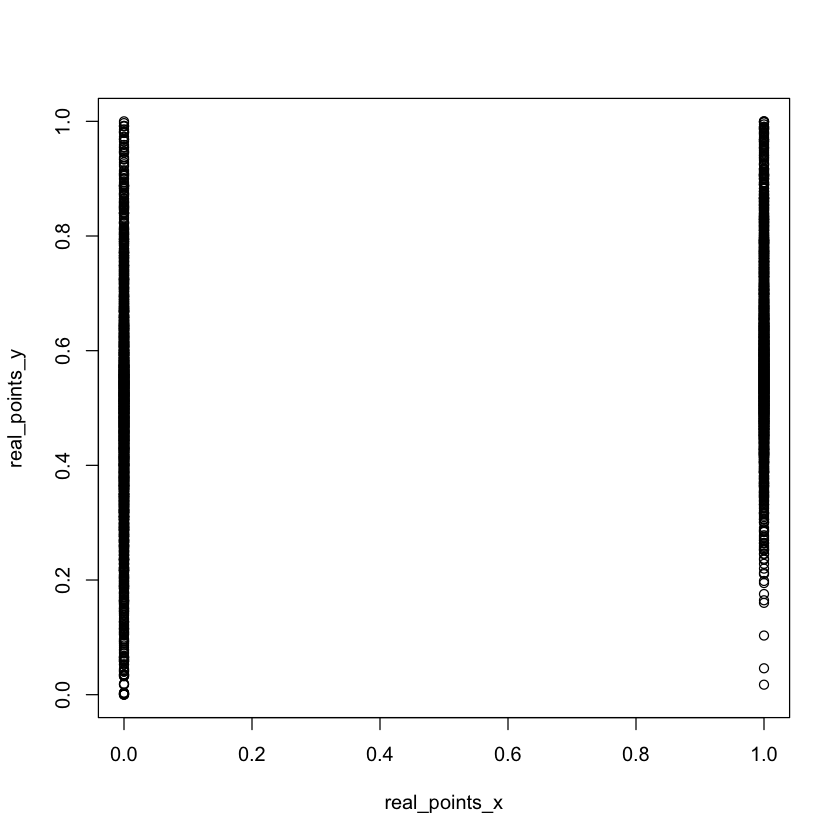

In [20]:
y1 <- predict(model, test_df, type="response")
x1 <- seq(1,601)

real_points_y <- predict(model, final_df, type='response')
real_points_x <- final_df$dup_type
plot(real_points_x, real_points_y)

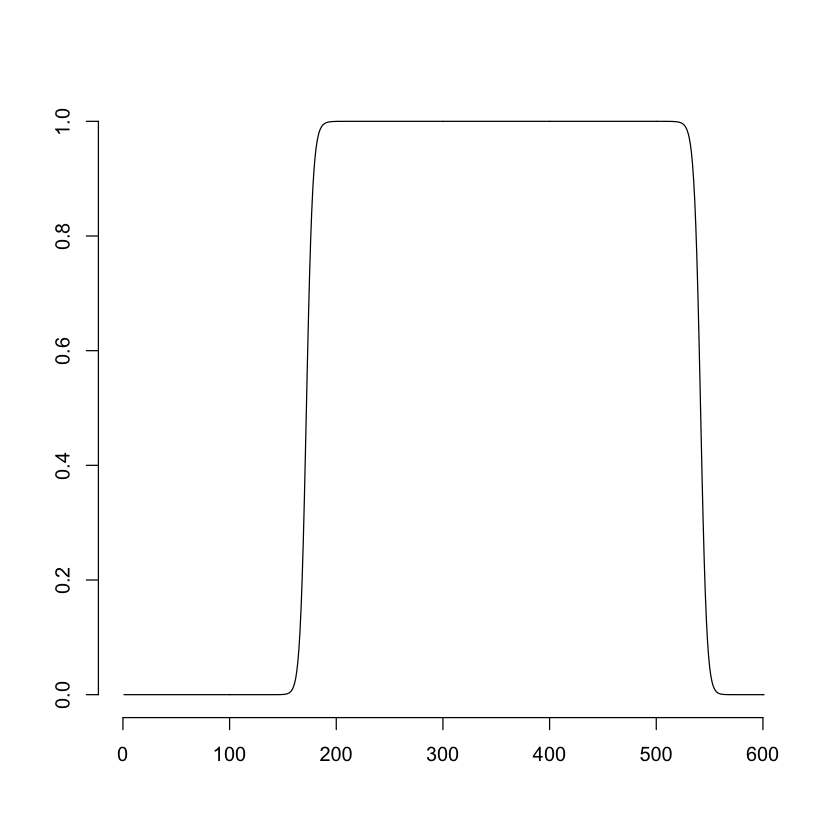

In [16]:
plot.new()

plot.window(xlim=c(1,601), ylim=c(0,1))
axis(1)
axis(2)

lines(x1,y1)
# plot(real_points_x, real_points_y)